<a href="https://colab.research.google.com/github/fabricio-franca/Data-Science/blob/main/ML_LGBM_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Definicao do Problema**

Análise Exploratória dos Dados (EDA):

Verificação de tipos de dados.
Identificação de valores ausentes.
Análise estatística das variáveis.
Detecção de outliers.
Pré-processamento dos Dados:

Tratamento de valores ausentes (se houver).
Codificação de variáveis categóricas (One-Hot Encoding).
Normalização/Padrãoização de variáveis numéricas.
Divisão em treino e teste.
Treinamento dos Modelos (XGBoost e LightGBM):

Ajuste dos modelos utilizando Grid Search para encontrar os melhores hiperparâmetros.
Treinamento com os melhores parâmetros.
Avaliação dos Modelos:

Relatório de classificação (precisão, recall, F1-score).
Matriz de confusão.
Feature Importance.

fonte: https://www.kaggle.com/code/emanuelcatao/creditcardfraud?select=card_transdata.csv




#**2. Coleta de dados**

In [2]:
!pip install xgboost lightgbm


In [3]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import lightgbm as lgb


In [11]:
# Carregar o dataset
df = pd.read_csv('card_transdata.csv')


In [12]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


# **3. Análise Exploratória dos Dados (EDA)**


In [13]:
print("Informações sobre os dados:")
print(df.info())

Informações sobre os dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB
None


In [17]:
print("\nEstatísticas descritivas:")

df.describe()


Estatísticas descritivas:


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
print("\nVerificando valores ausentes:")
print(df.isnull().sum())


Verificando valores ausentes:
distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64


In [16]:

# Detecção de outliers usando o método IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
print("\nQuantidade de outliers por variável:")
print(outliers)


Quantidade de outliers por variável:
distance_from_home                103631
distance_from_last_transaction    124367
ratio_to_median_purchase_price     84386
repeat_retailer                   118464
used_chip                              0
used_pin_number                   100608
online_order                           0
fraud                              87403
dtype: int64


# **4. Pré-processamento dos Dados**
# Separação entre variáveis independentes (X) e variável alvo (y)

In [18]:


y = df['fraud']  # Ajuste para a coluna alvo
X = df.drop(columns=['fraud'])  # Remover a variável alvo

In [19]:
# Identificar colunas categóricas e numéricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['number']).columns

In [20]:
# Codificação de variáveis categóricas, se houver
if len(categorical_cols) > 0:
    encoder = OneHotEncoder(drop='first', sparse=False)
    X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))
    X_encoded.columns = encoder.get_feature_names_out(categorical_cols)
    X = X.drop(columns=categorical_cols).reset_index(drop=True)
    X_encoded = X_encoded.reset_index(drop=True)
    X = pd.concat([X, X_encoded], axis=1)


In [21]:
X.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0


In [22]:
# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [23]:
# Normalização das variáveis numéricas
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


# **5. Treinamento dos Modelos (XGBoost e LightGBM) com Grid Search**
# Definição dos parâmetros para Grid Search


In [24]:
xgb_params = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

In [25]:
# Criando modelos base
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [26]:

# Grid Search para XGBoost
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [27]:
lgb_params = {
    'num_leaves': [31, 50, 80],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

In [28]:
#criando modelo base
lgb_model = lgb.LGBMClassifier()


In [29]:
# Grid Search para LightGBM
lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
lgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Number of positive: 69922, number of negative: 730078
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.087402 -> initscore=-2.345771
[LightGBM] [Info] Start training from score -2.345771


GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [31, 50, 80]},
             scoring='accuracy', verbose=2)

# **6. Avaliação dos Modelos**


In [30]:
# Melhor modelo XGBoost
best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

In [31]:

# Melhor modelo LightGBM
best_lgb = lgb_grid.best_estimator_
y_pred_lgb = best_lgb.predict(X_test)

In [32]:
# Relatórios de classificação
print("\nRelatório de Classificação - XGBoost:")
print(classification_report(y_test, y_pred_xgb))


Relatório de Classificação - XGBoost:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182519
         1.0       0.99      0.99      0.99     17481

    accuracy                           1.00    200000
   macro avg       1.00      0.99      0.99    200000
weighted avg       1.00      1.00      1.00    200000



In [33]:

print("\nRelatório de Classificação - LightGBM:")
print(classification_report(y_test, y_pred_lgb))


Relatório de Classificação - LightGBM:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182519
         1.0       0.99      0.99      0.99     17481

    accuracy                           1.00    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       1.00      1.00      1.00    200000



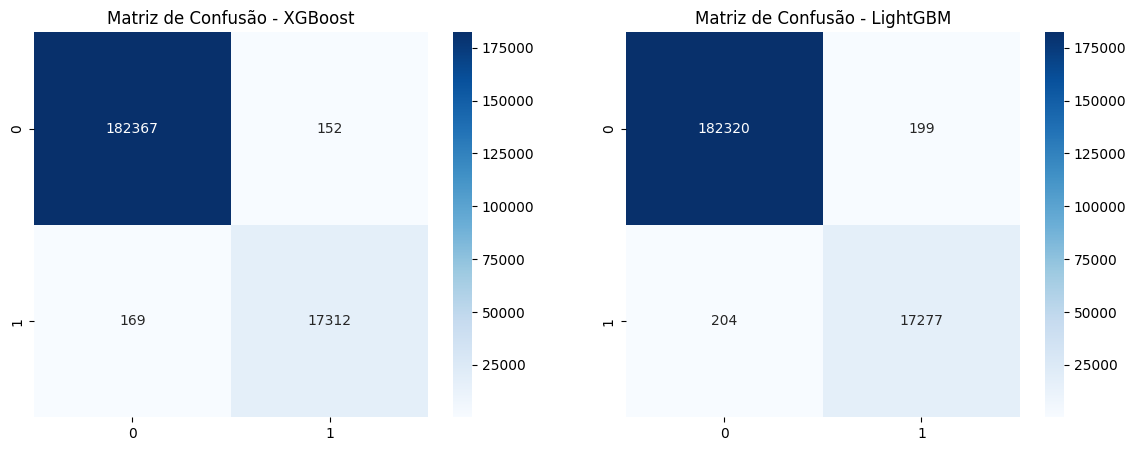

In [34]:



# Matriz de Confusão
xgb_cm = confusion_matrix(y_test, y_pred_xgb)
lgb_cm = confusion_matrix(y_test, y_pred_lgb)

# Visualizar Matriz de Confusão
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(xgb_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de Confusão - XGBoost")

sns.heatmap(lgb_cm, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Matriz de Confusão - LightGBM")

plt.show()


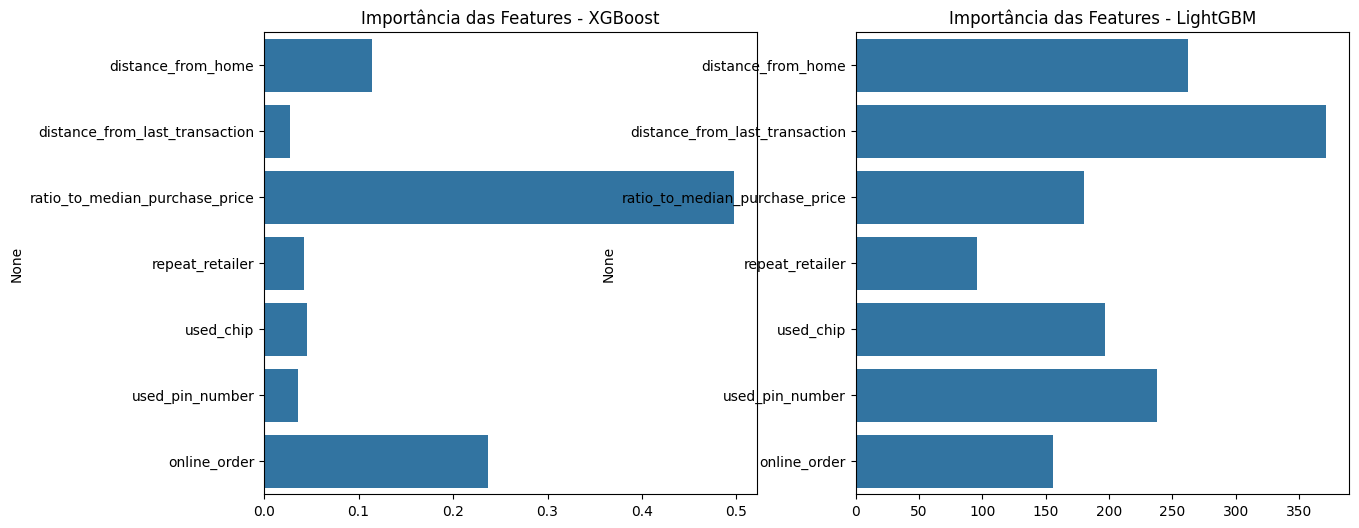

In [ ]:

# Feature Importance
xgb_importance = best_xgb.feature_importances_
lgb_importance = best_lgb.feature_importances_

# Criando gráficos de Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=xgb_importance, y=X.columns, ax=axes[0])
axes[0].set_title("Importância das Features - XGBoost")

sns.barplot(x=lgb_importance, y=X.columns, ax=axes[1])
axes[1].set_title("Importância das Features - LightGBM")

plt.show()


In [ ]:

# Exibir os melhores hiperparâmetros encontrados
print("\nMelhores hiperparâmetros XGBoost:", xgb_grid.best_params_)
print("Melhores hiperparâmetros LightGBM:", lgb_grid.best_params_)


Melhores hiperparâmetros XGBoost: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
Melhores hiperparâmetros LightGBM: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 31}


Prevendo novas transacoes

In [ ]:
def prever_transacao(modelo, scaler, colunas):
    """
    Função para prever se uma transação é fraude ou não.

    Parâmetros:
    - modelo: Modelo treinado (XGBoost ou LightGBM).
    - scaler: Objeto StandardScaler treinado.
    - colunas: Lista das colunas do dataset original (sem a coluna alvo).
    """

    print("\nDigite os valores para prever se a transação é fraude ou não:\n")
    entrada = []

    for coluna in colunas:
        valor = float(input(f"{coluna}: "))
        entrada.append(valor)

    # Converter entrada para dataframe
    df_entrada = pd.DataFrame([entrada], columns=colunas)

    # Normalizar os dados
    df_entrada[colunas] = scaler.transform(df_entrada[colunas])

    # Fazer a previsão
    previsao = modelo.predict(df_entrada)

    # Exibir resultado
    if previsao[0] == 1:
        print("\n🚨 A transação é possivelmente uma FRAUDE! 🚨")
    else:
        print("\n✅ A transação é segura (não é fraude).")


In [ ]:
prever_transacao(best_xgb, scaler, X.columns)  # Para prever usando XGBoost
# Ou use LightGBM
prever_transacao(best_lgb, scaler, X.columns)  # Para prever usando LightGBM



Digite os valores para prever se a transação é fraude ou não:

